In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [109]:
from collections import defaultdict
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
import seaborn as sns

from src import config
from src.evaluation.reporting import read_json_file

In [76]:
dataset = 'AID1445'
experiment = 'baseline_0'
data_usage = 'DROnly'

In [80]:
def _get_log_dir(dataset: str, experiment: str, data_usage: str) -> Path:
    return config.LOG_DIR / dataset / data_usage / experiment

In [75]:
datasets = ['AID1445', 'AID504329', 'AID624330', 'AID1465', 'AID1431-873', 'AID449756-435005', 'AID504313-2732', 'AID1259350-1224905']
metric_names = ['MeanAbsoluteError', 'RootMeanSquaredError', 'MaxError', 'PearsonCorrCoefSquared', 'R2Score', 'ConceptCompleteness']
proxy_names = ['NumParams', 'SynFlow', 'GradientNorm', 'JacobianCovariance', 'Snip', 'ZiCo', 'Grasp', 'Fisher']

In [55]:
def get_all_trial_results(log_dir: Path) -> pd.DataFrame:
    data = defaultdict(list)
    for p in log_dir.glob("*"):
        if p.is_dir():
            trial_id = p.name
            trial_metrics = read_json_file(p, 'metrics.json')
            trial_proxies = read_json_file(p, 'proxies.json')
            for version in trial_metrics:
                data['trial'].append(trial_id)
                data['version'].append(version)
                for name, metric in trial_metrics[version].items():
                    data[name].append(metric)
                for name, proxy in trial_proxies[version].items():
                    data[name].append(proxy)
    return pd.DataFrame(data)
                
    

In [56]:
experiment_df = get_all_trial_results(log_dir)

In [74]:
def _plot_proxy_metric_correlations(experiment_df: pd.DataFrame) -> plt.Axes:
    corrs = experiment_df.groupby('trial').mean().corr()
    return sns.heatmap(
        corrs[proxy_names].loc[metric_names, :],
        annot=True
    )

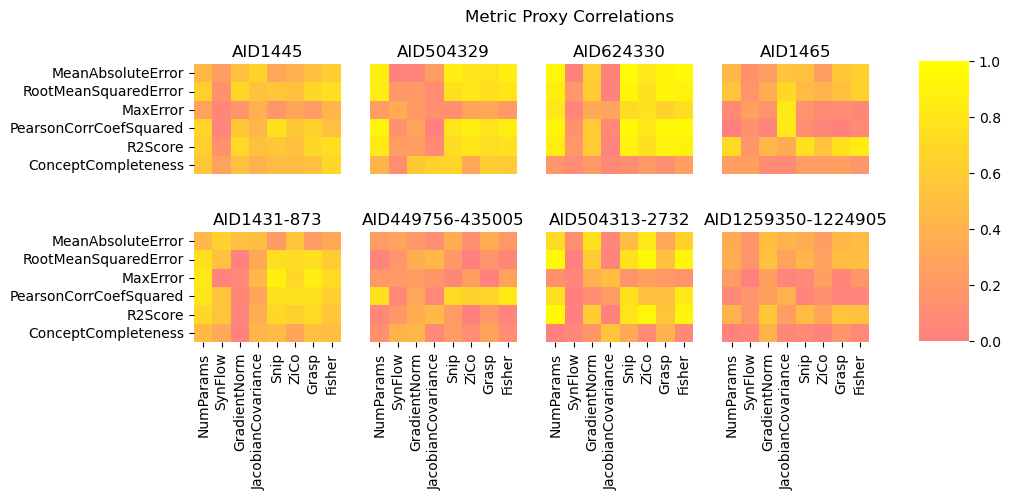

In [134]:
fig, axs = plt.subplots(2, 4)
fig.set_figwidth(10)
fig.set_figheight(4)
fig.suptitle("Metric Proxy Correlations")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#fig.colorbar(cm.ScalarMappable(), cax=cbar_ax)
for i, (ax, dataset) in enumerate(zip(axs.flatten(), datasets)):
    ax.set_title(dataset)
    experiment_df = get_all_trial_results(_get_log_dir(dataset, 'baseline_0', 'DROnly'))
    corrs = experiment_df.groupby('trial').mean().corr().abs()
    sns.heatmap(
        corrs[proxy_names].loc[metric_names, :],
        xticklabels=i >= 4,
        yticklabels=i == 0 or i == 4,
        annot=False,
        square=True,
        ax=ax,
        cmap='spring',
        cbar_ax=cbar_ax,
        vmin=0,
        vmax=1,
        center=0,
    )